# **DA5401 ASSIGNMENT-2** 
#### Author: *Vishwanath Vinod* (EE22B002)
#### Date:    5th September 2025

#### **IMPORTS**

In [ ]:
import os
import ast
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid')

## **A. EXPLORATORY DATA ANALYSIS**

#### **A.1 Analyzing Data**

In [96]:
# Read input dataset and visualize
df = pd.read_csv('./mushrooms.csv')
# get dataset shape and target variable distributions
print('Dataset Shape:', df.shape)
print('Dataset Columns:', list(df.columns))

target_col = df['class']
classes, counts = np.unique(target_col, return_counts=True)
for i, c in enumerate(classes):
    print('Class: {} Count: {} ({:.3f}%)'.format(c, counts[i], counts[i]*100./len(target_col)))
# check for any missing values
missing_values = df.isnull().sum()
print("NULL values: {} total".format(missing_values.sum()))
df[:5]

Dataset Shape: (8124, 23)
Dataset Columns: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Class: e Count: 4208 (51.797%)
Class: p Count: 3916 (48.203%)
NULL values: 0 total


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


#### **A.2 ONE-HOT ENCODING**

**Why is one-hot encoding necesary here?**

- All mushroom features are categorical (no inherent ordering)
- PCA needs numerical data to compute covariance matrices
- Using arbitrary class IDs for categorical variables introduces spurious correlations into the data as a model is likely to learn from the ordering of class IDs (ie. 1, 2, 3 etc.)
- One-hot encoding is the solution here. Encoding categorical variables at the ends of an n-dimensional hypercube does not introduce spurious correlations and maintains a meaningful notion of distance between categories.

In [97]:
# split features and target avriable
X = df.drop('class', axis=1)
Y = df['class']

print('Feature shape:', X.shape)
print('Target shape:', Y.shape)

# Perform one-hot encoding
X_encoded = pd.get_dummies(X)
print('Feature shape (after OH encoding):', X_encoded.shape)
X_encoded

Feature shape: (8124, 22)
Target shape: (8124,)
Feature shape (after OH encoding): (8124, 117)


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
8120,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
8121,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
8122,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,False


#### **A.3 STANDARDIZING ONE-HOT ENCODED FEATURES**

**Why is standardization important?**
- Some categories are much more common than others. Imbalanced categories have different variance than balanced categories.
- Since PCA is sensitive to the scale of features and to their relative variances, normalization is necessary

In [98]:
# standardization using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_encoded.columns)
X_scaled_df

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,2.347257,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,-0.193088,-0.404842,4.590870,-0.155582
1,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,1.667970,-0.337783,-0.193088,-0.404842,-0.217824,-0.155582
2,4.119885,-0.022195,-0.79621,-0.336878,-0.062885,-0.904579,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,5.178988,-0.404842,-0.217824,-0.155582
3,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,-0.677534,1.226505,...,2.347257,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,-0.193088,-0.404842,4.590870,-0.155582
4,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,1.667970,-0.337783,-0.193088,-0.404842,-0.217824,-0.155582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,-0.242725,-0.022195,-0.79621,2.968433,-0.062885,-0.904579,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,-0.599531,2.960477,-0.193088,-0.404842,-0.217824,-0.155582
8120,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,1.005431,-0.51672,-0.795385,-0.599531,2.960477,-0.193088,-0.404842,-0.217824,-0.155582
8121,-0.242725,-0.022195,1.25595,-0.336878,-0.062885,-0.904579,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,-0.599531,2.960477,-0.193088,-0.404842,-0.217824,-0.155582
8122,-0.242725,-0.022195,-0.79621,2.968433,-0.062885,-0.904579,-0.632238,-0.022195,-0.677534,1.226505,...,-0.426029,1.005431,-0.51672,-0.795385,-0.599531,2.960477,-0.193088,-0.404842,-0.217824,-0.155582


## **B. PRINCIPAL COMPONENT ANALYSIS**

We first carry out PCA and an analysis of the explained variance of the components to calculate the Principal Components needed to explain 95% of the variance.

#### **B.1 Performing PCA**

Initially we perform PCA without specifying the number of components after preprocessing the data.

In [99]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#### **B.2 Scree Plots for Explained Variance and Cummulative Explianed Variance**

Using these scree plots we find out the optimal number of components for PCA by aiming to retain 95% of the variance.

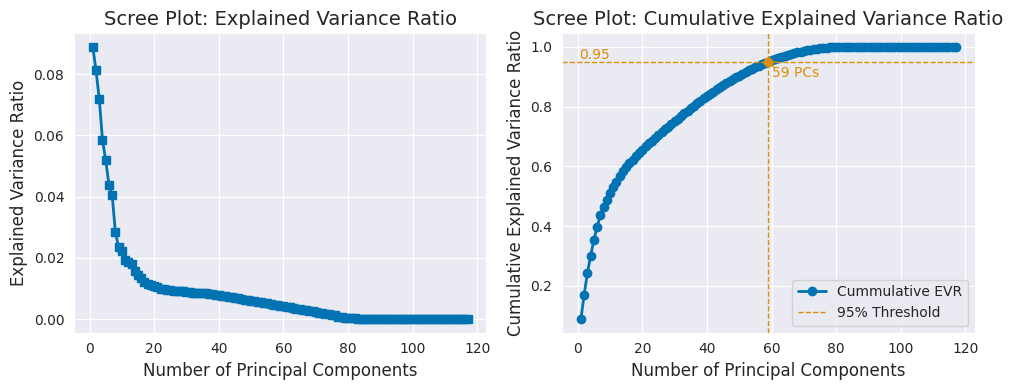

In [100]:
# Define colorblind-safe palette (Okabe–Ito)
colors = sns.color_palette("colorblind")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

pca_evr = pca.explained_variance_ratio_

# Explained variance ratio plot
axs[0].plot(range(1, pca.n_components_ + 1), pca_evr, 's-', 
            linewidth=2, color=colors[0])
axs[0].set_title('Scree Plot: Explained Variance Ratio', fontsize=14)
axs[0].set_xlabel('Number of Principal Components', fontsize=12)
axs[0].set_ylabel('Explained Variance Ratio', fontsize=12)

# Cumulative explained variance plot
cum_variances = np.cumsum(pca_evr)
axs[1].plot(range(1, pca.n_components_ + 1), cum_variances, 'o-', 
            linewidth=2, color=colors[0], label = 'Cummulative EVR')
axs[1].set_title('Scree Plot: Cumulative Explained Variance Ratio', fontsize=14)
axs[1].set_xlabel('Number of Principal Components', fontsize=12)
axs[1].set_ylabel('Cumulative Explained Variance Ratio', fontsize=12)

# --- Add 95% threshold line ---
threshold = 0.95
axs[1].axhline(y=threshold, color=colors[1], linestyle='--', linewidth=1)
axs[1].text(0.5, threshold, "0.95", color=colors[1], fontsize=10,
            va="bottom", ha="left")

# Find the number of components reaching >=95%
num_components_95 = np.argmax(cum_variances >= threshold) + 1

# Vertical line dropping to x-axis
axs[1].axvline(x=num_components_95, color=colors[1], linestyle='--', linewidth=1,label = '95% Threshold')

# Mark the intersection point
axs[1].scatter(num_components_95, threshold, color=colors[1], zorder=5)

# Annotate the point
axs[1].annotate(f'{num_components_95} PCs', 
                xy=(num_components_95, threshold), 
                xytext=(num_components_95+1, threshold-0.05),
                arrowprops=dict(arrowstyle="->", color=colors[1]),
                fontsize=10, color=colors[1])
axs[1].legend()

plt.tight_layout()
plt.show()



**Optimal Number of Components for PCA**

Based on the scree plots above the optimal number of components should be **59**.

In [101]:
# Finding optimal number of PCs (for 95% EVR)
comp95 = np.argmax(cum_variances >= 0.95) + 1
print('PCs for 95% Explained Variance Ratio: {}'.format(comp95))

PCs for 95% Explained Variance Ratio: 59


#### **B.3 VISUALIZATION**

We analyze the seperatibility of the classes in reduced feature spaces by visualizing pair plots of data on Principal component dimensions.\
Since the number of Principal Components (59) is high, we visualize the pair plots of the top 4 dimensions using pair plots.

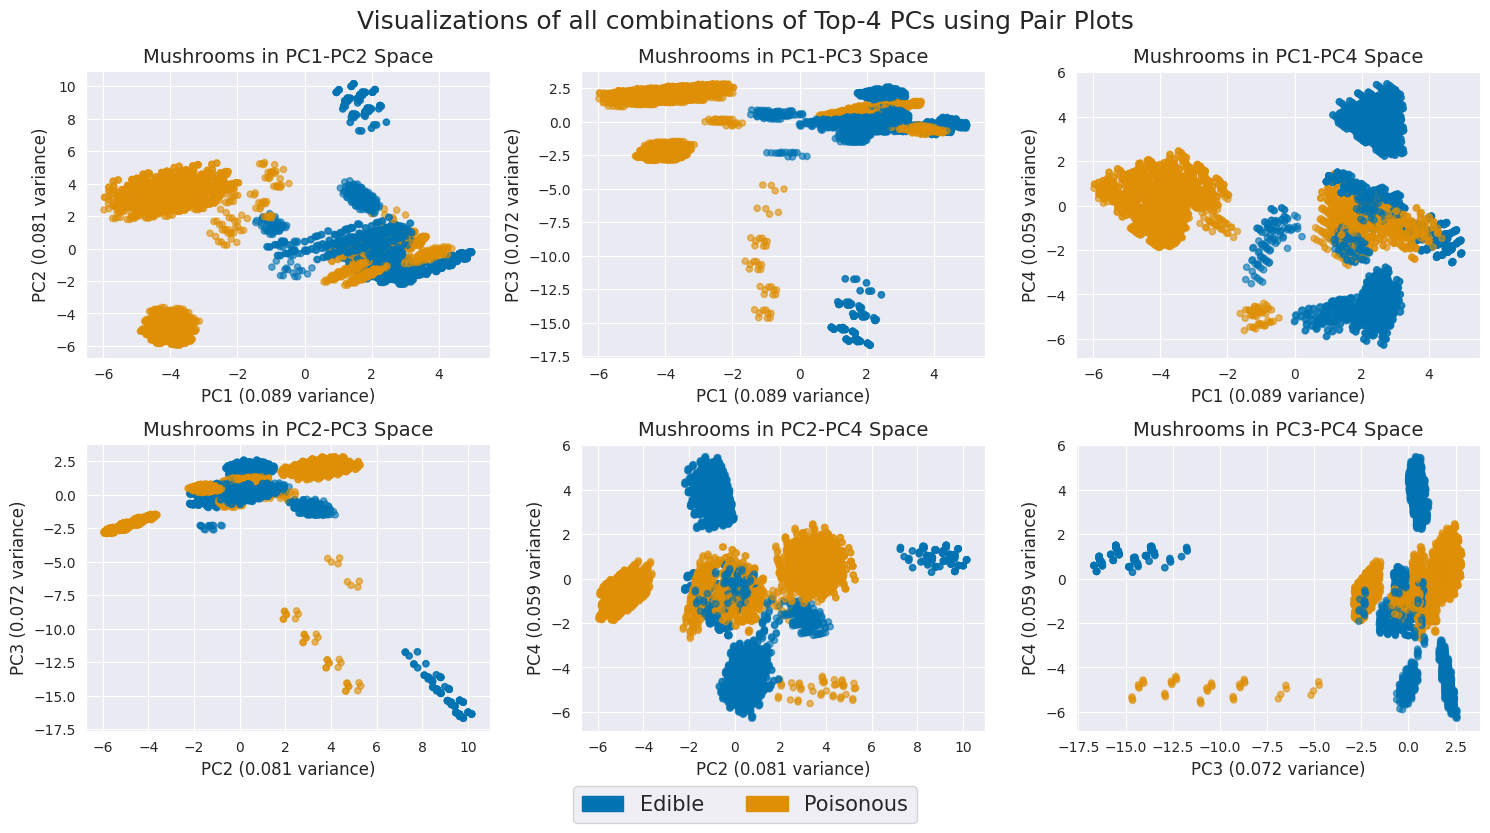

In [ ]:
# Two colors: edible (0), poisonous (1)
colors = sns.color_palette("colorblind")[:2]
cmap = ListedColormap(colors)
Y = Y.map({'e': 0, 'p': 1}).values

# All pairs of the first 4 PCs
pairs = list(combinations(range(4), 2))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, (i, j) in zip(axes.ravel(), pairs):
    ax.scatter(X_pca[:, i], X_pca[:, j], c=Y, cmap=cmap, alpha=0.6, s=20)
    ax.set_xlabel(f'PC{i+1} ({pca_evr[i]:.3f} variance)', fontsize=12)
    ax.set_ylabel(f'PC{j+1} ({pca_evr[j]:.3f} variance)', fontsize=12)
    ax.set_title(f'Mushrooms in PC{i+1}-PC{j+1} Space', fontsize=14)

# Legend
patch1 = mpatches.Patch(color=colors[0], label='Edible')
patch2 = mpatches.Patch(color=colors[1], label='Poisonous')
fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2,
           labelspacing=1, bbox_to_anchor=(0.5, -0.05), fontsize=15)

fig.suptitle('Visualizations of all combinations of Top-4 PCs using Pair Plots', fontsize=18)
plt.tight_layout()
plt.show()


**OBSERVATION**
\
From the top-4 principal components (which explain $\approx30\%$ of the variance) we can see that while several clusters of data points are well separated when visualized using only 2 components, several other clusters show significant overlap across both categories of mushrooms (ie. poisonous and edible).
These areas are not well separated enough, indicating that an even larger number of principal components is needed to capture the spread of data better.

## **C. Performance Evaluation using Logistic Regression**

We evaluate Logistic Regression performance on the dataset both before and after applying PCA, using it as a metric to assess the effectiveness of PCA.

#### **C.1 Baseline Model**

Perform Logistic Regression on the standardized pre-processed data before implementing PCA to act as a baseline for comparing the results after implementing PCA.

In [116]:
# train-test split (80%-20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
# Perform Logisitc Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, Y_train)
Y_pred1 = lr.predict(X_test)

#print(classification_report(Y_test, Y_pred1))
report_dict = classification_report(Y_test, Y_pred1, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("CLASSIFICATION REPORT\n")
print(report_df)
print('\nClassification Accuracy: {}%'.format(sum(Y_test==Y_pred1)*100./len(Y_test))) 

CLASSIFICATION REPORT

              precision  recall  f1-score  support
0                   1.0     1.0       1.0    843.0
1                   1.0     1.0       1.0    782.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1625.0
weighted avg        1.0     1.0       1.0   1625.0

Classification Accuracy: 100.0%


**OBSERVATION**\
We obtain 100% classification accuracy using the original standardized pre-processed data. \
The Logistic Regression Classifier correctly classified mushrooms as edible or poisonous with 100% accuracy.

#### **C.2 PCA Transformed Model**

We anlayze the perform of the Logisitic Regression Classifier on the data after performing PCA.\
We compare this with the Baseline Model and thus get a qualitative understanding of whether reducing the dimensionality decreased or increased the performance.

In [117]:
# optimal number of components
num = 59

# Fit PCA on train set and transform both sets (with 59 components)
pca = PCA(n_components = num)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

# Train LR Classifier on PCA data
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_pca_train, Y_train)
Y_pred2 = lr.predict(X_pca_test)
report_dict = classification_report(Y_test, Y_pred2, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("CLASSIFICATION REPORT\n")
print(report_df)
print('\nClassification Accuracy: {}%'.format(sum(Y_test==Y_pred2)*100./len(Y_test))) 

CLASSIFICATION REPORT

              precision  recall  f1-score  support
0                   1.0     1.0       1.0    843.0
1                   1.0     1.0       1.0    782.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1625.0
weighted avg        1.0     1.0       1.0   1625.0

Classification Accuracy: 100.0%


**OBSERVATION**\
We obtain 100% classification accuracy after implementing PCA on the data. \
The Logistic Regression Classifier correctly classified mushrooms as edible or poisonous with 100% accuracy.

#### **C.3 COMPARISON AND ANALYSIS**

The following points are immediately obvious from the two sets of results:

1. Since the classification accuracy is 100% in both cases, there is no significant performance difference between using PCA-reduced features and the original feature set. This suggests that the dimensionality reduction did not cause meaningful information loss for the task at hand—the essential discriminative information was already contained in a lower-dimensional subspace.
2. PCA’s ability to handle feature collinearity and redundancy did not provide a noticeable benefit here, likely because the original dataset was already well-conditioned for classification, and Logistic Regression could effectively separate the classes without suffering from multicollinearity issues.

**Logistic Regression as a Surrogate Performance Measurement for Evaluating the effect of PCA**

Logistic Regression is used as a surrogate metric because it is a simple linear classifier whose performance depends on the quality of the feature representation. If PCA removes essential information, accuracy will decline; if it primarily reduces redundancy, noise, or collinearity, accuracy can improve or remain unchanged. In this way, Logistic Regression provides a practical means to evaluate whether PCA enhances or preserves the discriminative structure of the data.

##  **ADDITIONAL EXPERIMENTS**

Evaluting the effect of number of components in the PCA on the accuracy of the Logistic Regression Classifier.

In [118]:
components_range = range(1, X_train.shape[1] + 1)
colors = sns.color_palette("colorblind")

# Metrics storage
accuracies = []
precisions = []
recalls = []
f1_scores = []

for num in components_range:
    # Fit PCA
    pca = PCA(n_components=num, random_state=42)
    X_pca_train = pca.fit_transform(X_train)
    X_pca_test = pca.transform(X_test)
    
    # Train LR classifier
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_pca_train, Y_train)
    Y_pred = lr.predict(X_pca_test)
    
    # Store metrics (macro averages for multiclass)
    accuracies.append(accuracy_score(Y_test, Y_pred))
    precisions.append(precision_score(Y_test, Y_pred, average='macro'))
    recalls.append(recall_score(Y_test, Y_pred, average='macro'))
    f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))


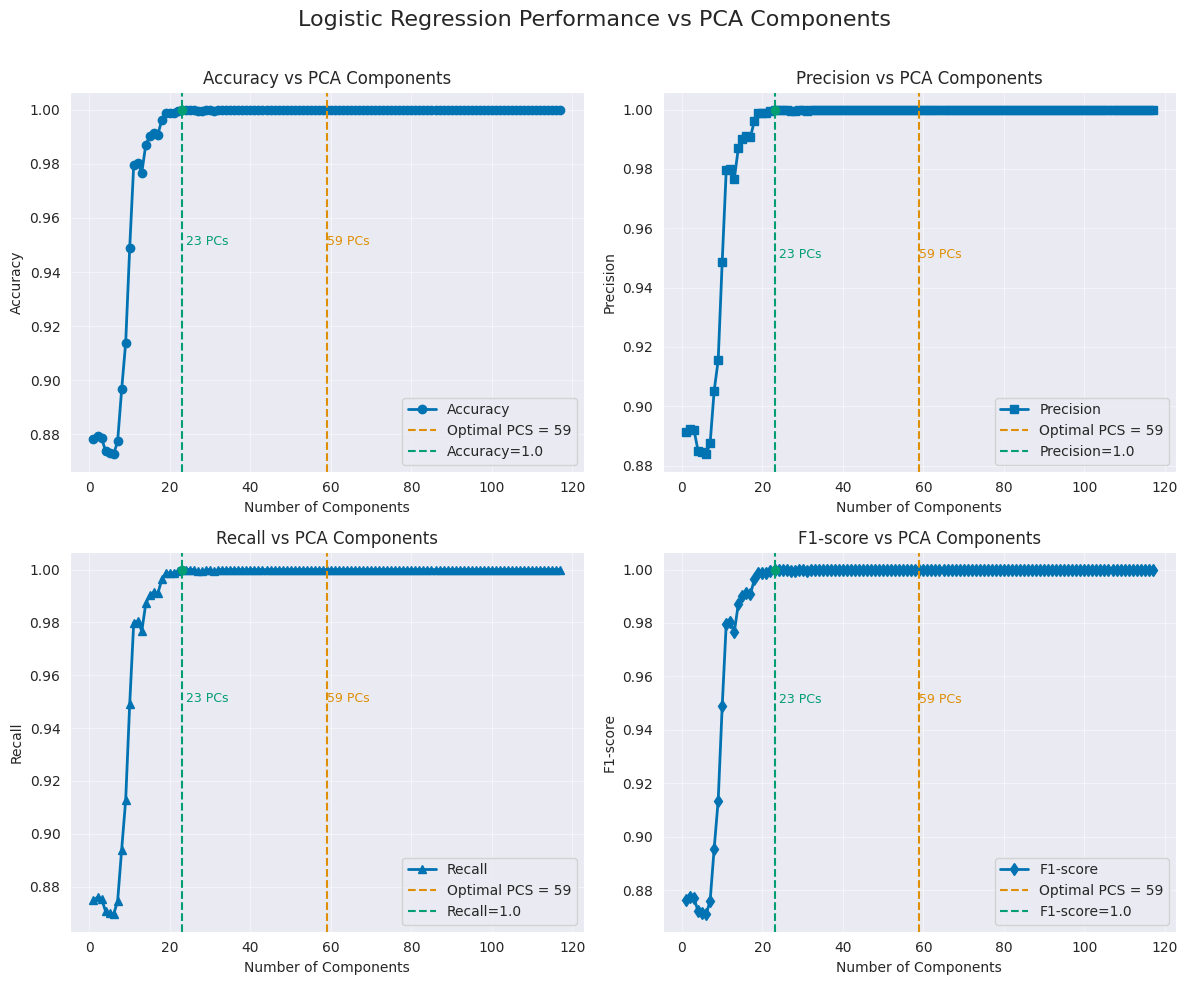

In [119]:
# ---- Plot 2x2 subplots ----
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

metrics = {
    "Accuracy": (accuracies, "o"),
    "Precision": (precisions, "s"),
    "Recall": (recalls, "^"),
    "F1-score": (f1_scores, "d")
}

# Iterate over subplots and metrics
for ax, (title, (values, marker)) in zip(axs.ravel(), metrics.items()):
    # Plot metric curve
    ax.plot(components_range, values, marker=marker, color=colors[0], linewidth=2, label=title)
    # Mark 59 components
    ax.axvline(x=59, color=colors[1], linestyle='--', label="Optimal PCS = 59")
    ax.text(59, 1.0-0.05, f"59 PCs", color=colors[1], fontsize=9)
    # Check where metric first reaches 1.0
    if any(np.isclose(values, 1.0)):
        comp_at_1 = components_range[np.argmax(np.isclose(values, 1.0))]
        ax.axvline(x=comp_at_1, color=colors[2], linestyle='--', label=f"{title}=1.0")
        ax.scatter(comp_at_1, 1.0, color=colors[2], zorder=5)
        ax.text(comp_at_1+1, 1.0-0.05, f"{comp_at_1} PCs", color=colors[2], fontsize=9)
    
    # Labels and grid
    ax.set_title(f"{title} vs PCA Components")
    ax.set_xlabel("Number of Components")
    ax.set_ylabel(title)
    ax.grid(alpha=0.5)
    ax.legend()

plt.suptitle("Logistic Regression Performance vs PCA Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**OBSERVATIONS** 
1. For number of Principal Components >=23 we get 100% classification accuracy. 
2. All classification scores increase with increase in dimensionality upto that point and then remain stable.